In [219]:
import os
import random
import requests
import warnings
from datetime import datetime

import holidays
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suppress warnings
warnings.filterwarnings('ignore')

# Statistical and ML libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif

# Time series specific libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy import stats 

# Deep learning libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [220]:
df = pd.read_csv(r'C:\Users\LENOVO\MachineLearningProhects\TimeSeriesForecasting_End_To_End\data\raw\twitter_x_forecast.csv')

In [221]:
df.head(5)

,time,temp_max_C,temp_min_C,precip_mm,day_of_week,month,wind_speed_max_m_s,weather_code,Complaint_Count,year,relative_humidity_2m_mean,weather_label
0,2022-06-10,41.0,30.3,0.1,4,6,16.6,51,10,2022,47,1
1,2022-06-11,41.0,30.8,0.2,5,6,25.3,51,12,2022,42,1
2,2022-06-12,39.8,29.5,0.0,6,6,16.7,3,5,2022,45,3
3,2022-06-13,40.2,29.5,0.0,0,6,13.3,3,15,2022,45,3
4,2022-06-14,39.2,30.0,8.6,1,6,19.0,63,16,2022,52,0


In [222]:
df.shape

(1228, 12)

### Outlier Detection Z-score

In [223]:
# Step 1: Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Step 2: Compute Z-scores (use ddof=0 to avoid NaN issues)
z_scores = np.abs(stats.zscore(numeric_df, nan_policy='omit'))

# Convert to DataFrame for visualization
z_scores_df = pd.DataFrame(z_scores, columns=numeric_df.columns)

# Step 3: Define threshold (try 3.0 or 3.5 — 3.9 is too high)
threshold = 3.9

# Step 4: Identify and remove outliers
filtered_entries = (z_scores_df < threshold).all(axis=1)
df_cleaned = df[filtered_entries].reset_index(drop=True)

# Outlier DataFrame (rows where any feature exceeds threshold)
outlier_df = df[~filtered_entries].reset_index(drop=True)


In [224]:
df_cleaned.head(2)

,time,temp_max_C,temp_min_C,precip_mm,day_of_week,month,wind_speed_max_m_s,weather_code,Complaint_Count,year,relative_humidity_2m_mean,weather_label
0,2022-06-10,41.0,30.3,0.1,4,6,16.6,51,10,2022,47,1
1,2022-06-11,41.0,30.8,0.2,5,6,25.3,51,12,2022,42,1


In [225]:
df_cleaned.shape

(1200, 12)

In [226]:
df_cleaned.columns

Index(['time', 'temp_max_C', 'temp_min_C', 'precip_mm', 'day_of_week', 'month',
       'wind_speed_max_m_s', 'weather_code', 'Complaint_Count', 'year',
       'relative_humidity_2m_mean', 'weather_label'],
      dtype='object')

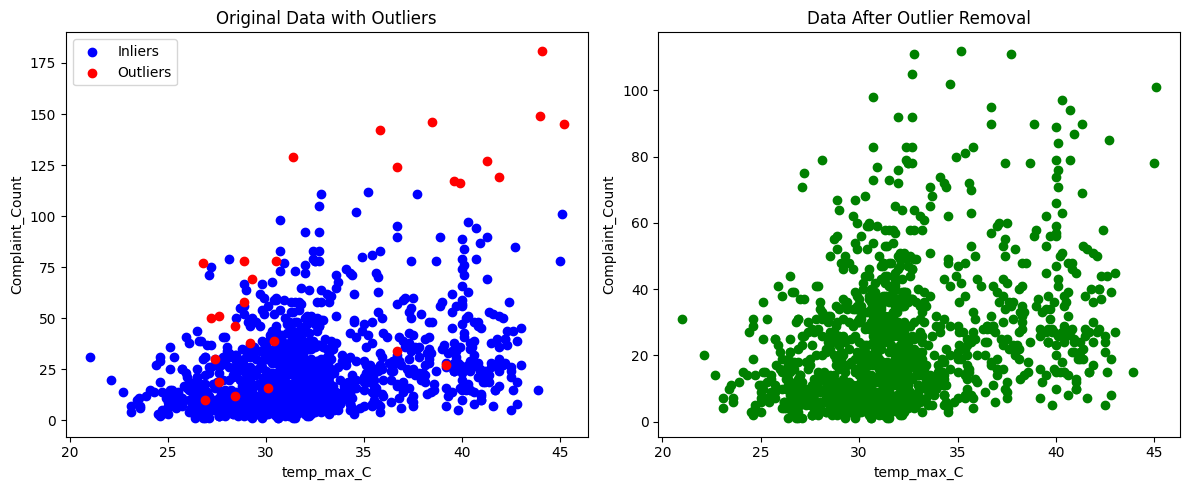

In [227]:
import matplotlib.pyplot as plt

# Step 5: Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Define outliers
outliers = ~filtered_entries

# Choose two numeric features for plotting (adjust as needed)
x_col = 'temp_max_C'
y_col = 'Complaint_Count'

# Plot original data with outliers in red
axes[0].scatter(df.loc[filtered_entries, x_col], df.loc[filtered_entries, y_col], color='blue', label='Inliers')
axes[0].scatter(df.loc[outliers, x_col], df.loc[outliers, y_col], color='red', label='Outliers')
axes[0].set_title('Original Data with Outliers')
axes[0].set_xlabel(x_col)
axes[0].set_ylabel(y_col)
axes[0].legend()

# Plot cleaned data
axes[1].scatter(df_cleaned[x_col], df_cleaned[y_col], color='green')
axes[1].set_title('Data After Outlier Removal')
axes[1].set_xlabel(x_col)
axes[1].set_ylabel(y_col)

plt.tight_layout()
plt.show()


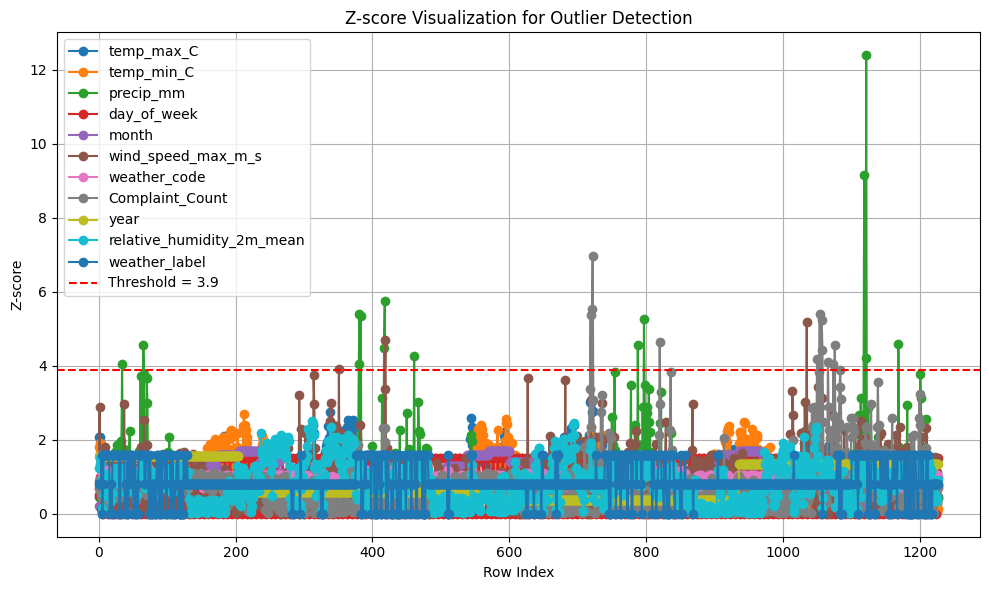

In [228]:
# Step 5: Visualize Z-scores
plt.figure(figsize=(10, 6))
for col in z_scores_df.columns:
    plt.plot(z_scores_df.index, z_scores_df[col], marker='o', label=col)

plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.title('Z-score Visualization for Outlier Detection')
plt.xlabel('Row Index')
plt.ylabel('Z-score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

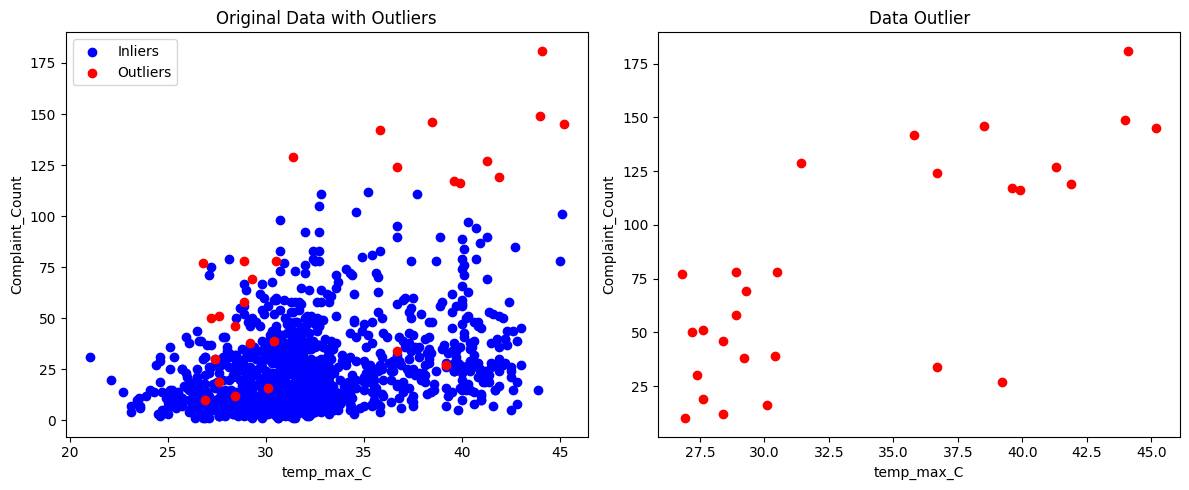

In [233]:
import matplotlib.pyplot as plt

# Step 5: Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Define outliers
outliers = ~filtered_entries

# Choose two numeric features for plotting (adjust as needed)
x_col = 'temp_max_C'
y_col = 'Complaint_Count'

# Plot original data with outliers in red
axes[0].scatter(df.loc[filtered_entries, x_col], df.loc[filtered_entries, y_col], color='blue', label='Inliers')
axes[0].scatter(df.loc[outliers, x_col], df.loc[outliers, y_col], color='red', label='Outliers')
axes[0].set_title('Original Data with Outliers')
axes[0].set_xlabel(x_col)
axes[0].set_ylabel(y_col)
axes[0].legend()

# Plot cleaned data
axes[1].scatter(outlier_df[x_col], outlier_df[y_col], color='red')
axes[1].set_title('Data Outlier')
axes[1].set_xlabel(x_col)
axes[1].set_ylabel(y_col)

plt.tight_layout()
plt.show()


In [247]:
df.head(2)

,time,temp_max_C,temp_min_C,precip_mm,day_of_week,month,wind_speed_max_m_s,weather_code,Complaint_Count,year,relative_humidity_2m_mean,weather_label
0,2022-06-10,41.0,30.3,0.1,4,6,16.6,51,10,2022,47,1
1,2022-06-11,41.0,30.8,0.2,5,6,25.3,51,12,2022,42,1


In [246]:
df.columns

Index(['time', 'temp_max_C', 'temp_min_C', 'precip_mm', 'day_of_week', 'month',
       'wind_speed_max_m_s', 'weather_code', 'Complaint_Count', 'year',
       'relative_humidity_2m_mean', 'weather_label'],
      dtype='object')

### Interquartile Range (IQR) Method:

In [248]:
import pandas as pd

# Example: assuming you already have a DataFrame `df`
# Step 1: Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Step 2: Calculate IQR for each column
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

# Step 3: Define filter condition (keep only non-outliers)
# This will create a boolean DataFrame and then select rows with all True
filtered_df = df[~((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Step 4: Reset index (optional)
filtered_df = filtered_df.reset_index(drop=True)


In [249]:
print("Original Shape:", df.shape)
print("Filtered Shape:", filtered_df.shape)

Original Shape: (1228, 12)
Filtered Shape: (941, 12)


In [250]:
outlier_mask = (numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))
outlier_count = outlier_mask.sum()
print(outlier_count)

temp_max_C                    58
temp_min_C                     0
precip_mm                    175
day_of_week                    0
month                          0
wind_speed_max_m_s            21
weather_code                   0
Complaint_Count               64
year                           0
relative_humidity_2m_mean      0
weather_label                  0
dtype: int64


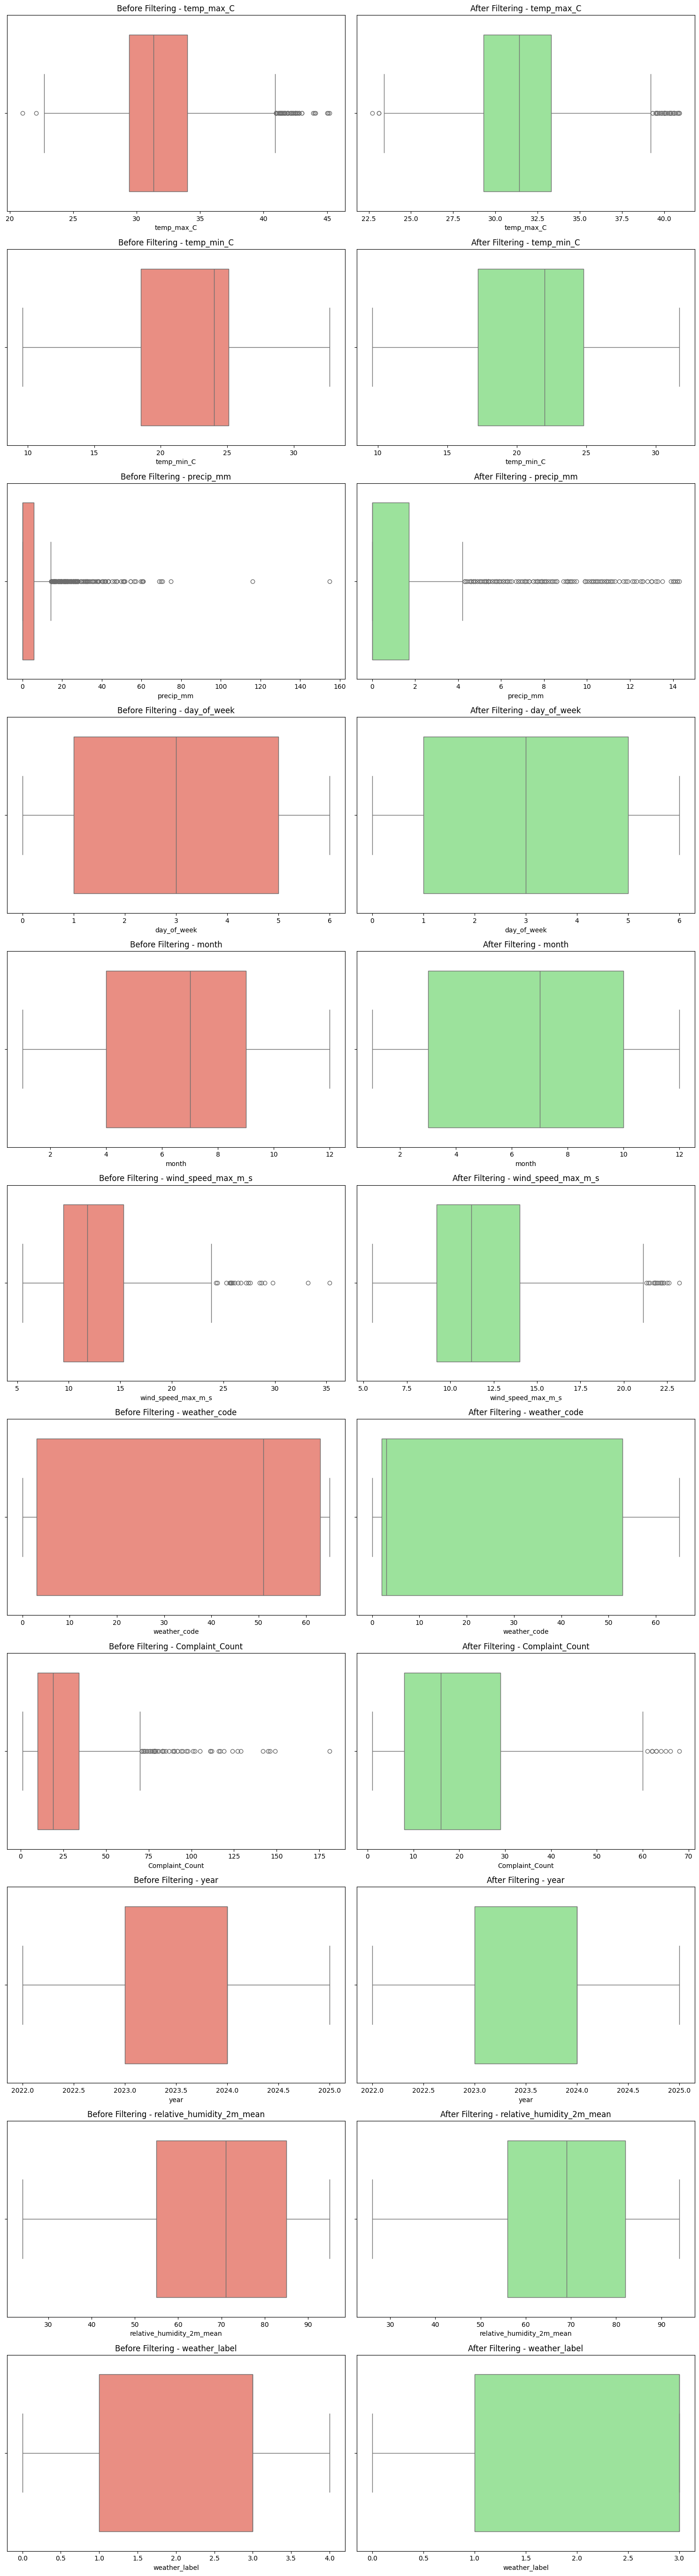

In [252]:
# --- Step 4: Visualization before vs after filtering ---
numeric_cols = numeric_df.columns

# Set figure size
plt.figure(figsize=(15, 5 * len(numeric_cols)))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 2, 2*i - 1)
    sns.boxplot(x=df[col], color='salmon')
    plt.title(f"Before Filtering - {col}")

    plt.subplot(len(numeric_cols), 2, 2*i)
    sns.boxplot(x=filtered_df[col], color='lightgreen')
    plt.title(f"After Filtering - {col}")

plt.tight_layout()
plt.show()

In [253]:
filtered_df.head()

,time,temp_max_C,temp_min_C,precip_mm,day_of_week,month,wind_speed_max_m_s,weather_code,Complaint_Count,year,relative_humidity_2m_mean,weather_label
0,2022-06-12,39.8,29.5,0.0,6,6,16.7,3,5,2022,45,3
1,2022-06-13,40.2,29.5,0.0,0,6,13.3,3,15,2022,45,3
2,2022-06-14,39.2,30.0,8.6,1,6,19.0,63,16,2022,52,0
3,2022-06-15,35.6,26.1,6.0,2,6,17.4,63,15,2022,66,2
4,2022-06-16,36.8,26.5,0.6,3,6,15.3,53,11,2022,68,1


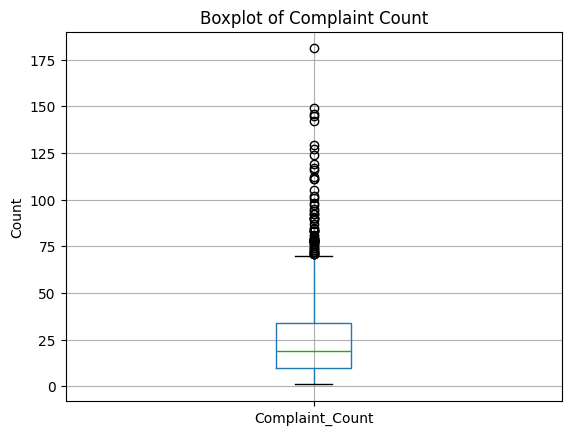

In [255]:
df.boxplot(column='Complaint_Count')
plt.title('Boxplot of Complaint Count')
plt.ylabel('Count')
plt.show()

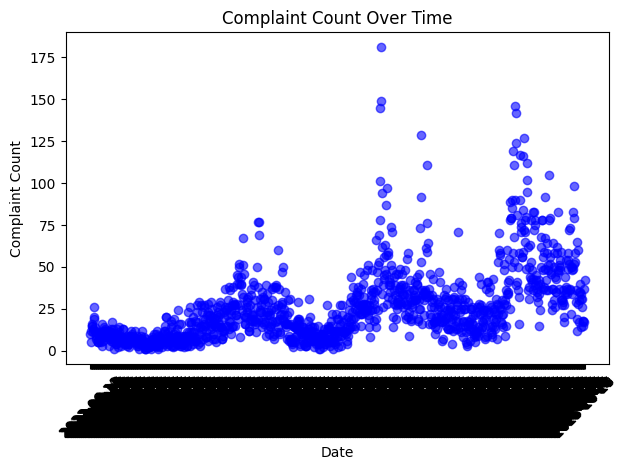

In [256]:
plt.scatter(df['time'], df['Complaint_Count'], color='blue', alpha=0.6)
plt.title('Complaint Count Over Time')
plt.xlabel('Date')
plt.ylabel('Complaint Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Outlier bounds → Lower: -26.00, Upper: 70.00
Original Shape: (1228, 12)
Filtered Shape: (1164, 12)


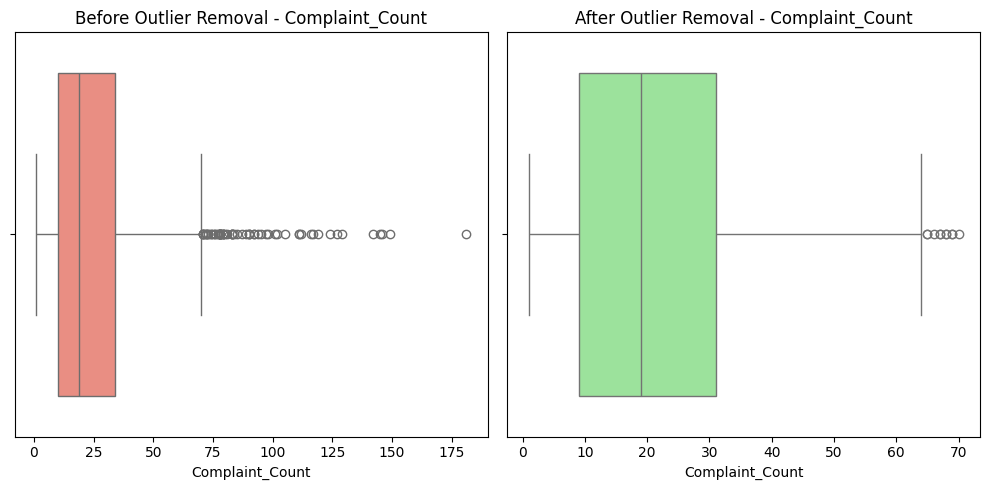

In [271]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Define your target column name ---
target_col = 'Complaint_Count'   # 🔁 change this to your target column name

# --- Step 2: Compute IQR for the target column ---
Q1 = df[target_col].quantile(0.25)
Q3 = df[target_col].quantile(0.75)
IQR = Q3 - Q1

# --- Step 3: Define lower and upper bounds ---
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# --- Step 4: Filter DataFrame based on target only ---
filtered_d = df[(df[target_col] >= lower_bound) & (df[target_col] <= upper_bound)]

# --- Step 5: Reset index (optional) ---
filtered_d = filtered_d.reset_index(drop=True)

print(f"Outlier bounds → Lower: {lower_bound:.2f}, Upper: {upper_bound:.2f}")
print("Original Shape:", df.shape)
print("Filtered Shape:", filtered_d.shape)

# --- Step 6: Visualization (before vs after) ---
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df[target_col], color='salmon')
plt.title(f"Before Outlier Removal - {target_col}")

plt.subplot(1, 2, 2)
sns.boxplot(x=filtered_d[target_col], color='lightgreen')
plt.title(f"After Outlier Removal - {target_col}")

plt.tight_layout()
plt.show()


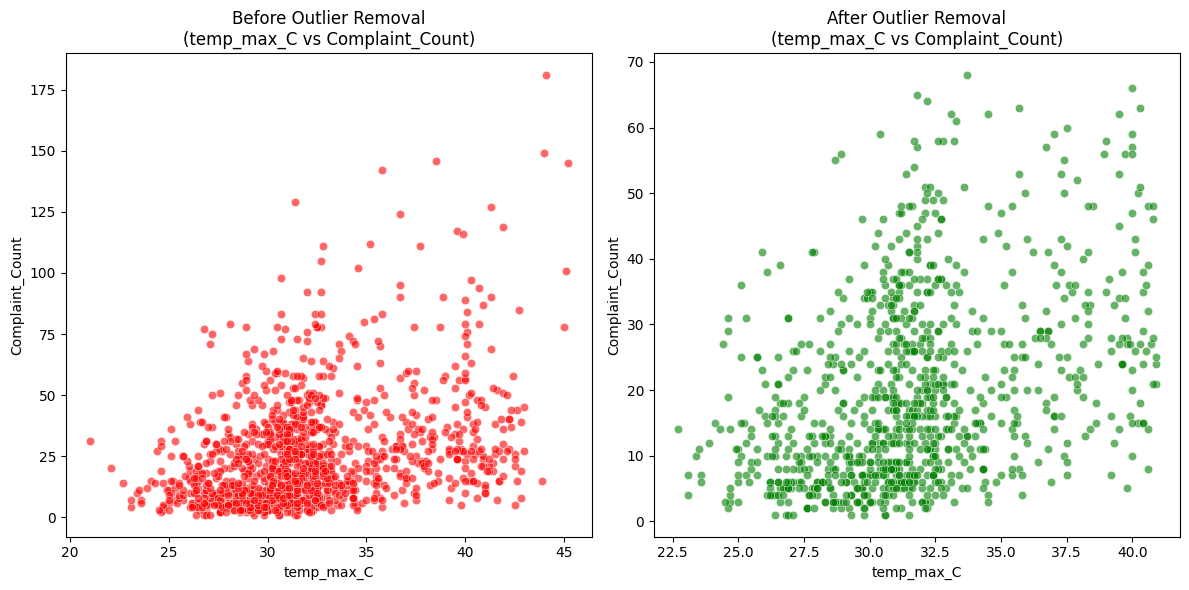

In [263]:
# Before outlier removal
plt.figure(figsize=(12, 6))
x_feature = 'temp_max_C'
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x=x_feature , y=target_col, color='red', alpha=0.6)
plt.title(f"Before Outlier Removal\n({x_feature} vs {target_col})")

# After outlier removal
plt.subplot(1, 2, 2)
sns.scatterplot(data=filtered_df, x=x_feature, y=target_col, color='green', alpha=0.6)
plt.title(f"After Outlier Removal\n({x_feature} vs {target_col})")

plt.tight_layout()
plt.show()

Outlier bounds → Lower: -38.00, Upper: 82.00
Original shape: (1228, 12)
Filtered shape: (1194, 12)


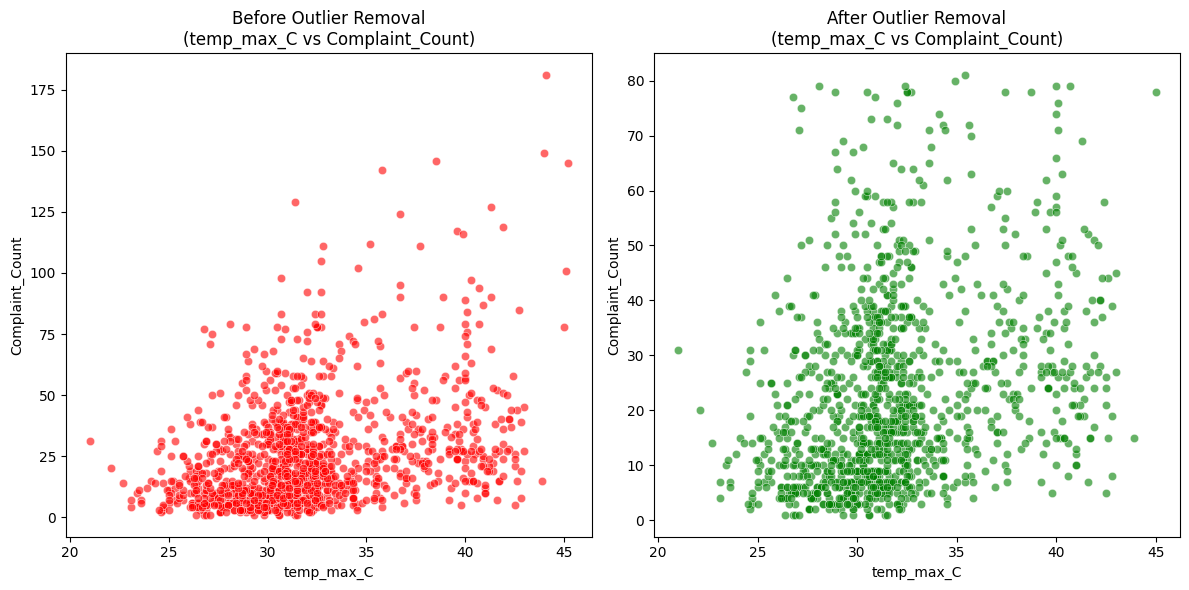

In [273]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

target_col = 'Complaint_Count'      # your target variable
x_feature = 'temp_max_C'  # your chosen x-axis feature
factor = 2.0               # 👈 adjust this (1.0, 1.5, 2.0, 3.0...)

Q = df[target_col].quantile(0.25)
Q1 = df[target_col].quantile(0.75)
I = Q1 - Q

lower = Q - factor * I
upper = Q1 + factor * I

filtered_f = df[(df[target_col] >= lower) & (df[target_col] <= upper)]
filtered_f = filtered_f.reset_index(drop=True)

print(f"Outlier bounds → Lower: {lower:.2f}, Upper: {upper:.2f}")
print("Original shape:", df.shape)
print("Filtered shape:", filtered_f.shape)

# Scatter plot comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x=x_feature, y=target_col, color='red', alpha=0.6)
plt.title(f"Before Outlier Removal\n({x_feature} vs {target_col})")

plt.subplot(1, 2, 2)
sns.scatterplot(data=filtered_f, x=x_feature, y=target_col, color='green', alpha=0.6)
plt.title(f"After Outlier Removal\n({x_feature} vs {target_col})")

plt.tight_layout()
plt.show()


In [274]:
print('ok')

ok


In [275]:
df.describe()

,temp_max_C,temp_min_C,precip_mm,day_of_week,month,wind_speed_max_m_s,weather_code,Complaint_Count,year,relative_humidity_2m_mean,weather_label
count,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000
mean,32.138355,21.951140,5.645847,3.004886,6.676710,12.762622,30.630293,25.571661,2023.606678,68.773616,2.003257
std,4.291665,4.592986,12.035461,2.001216,3.317319,4.337403,28.983065,22.271619,1.024168,17.753750,1.253516
min,21.000000,9.600000,0.000000,0.000000,1.000000,5.500000,0.000000,1.000000,2022.000000,24.000000,0.000000
25%,29.400000,18.500000,0.000000,1.000000,4.000000,9.500000,3.000000,10.000000,2023.000000,55.000000,1.000000
50%,31.350000,24.000000,0.100000,3.000000,7.000000,11.800000,51.000000,19.000000,2024.000000,71.000000,3.000000
75%,34.000000,25.100000,5.725000,5.000000,9.000000,15.300000,63.000000,34.000000,2024.000000,85.000000,3.000000
max,45.200000,32.700000,154.800000,6.000000,12.000000,35.300000,65.000000,181.000000,2025.000000,95.000000,4.000000


Manual Outlier Cutoffs → Lower: 2, Upper: 80
Original Shape: (1228, 12)
Filtered Shape: (1183, 12)


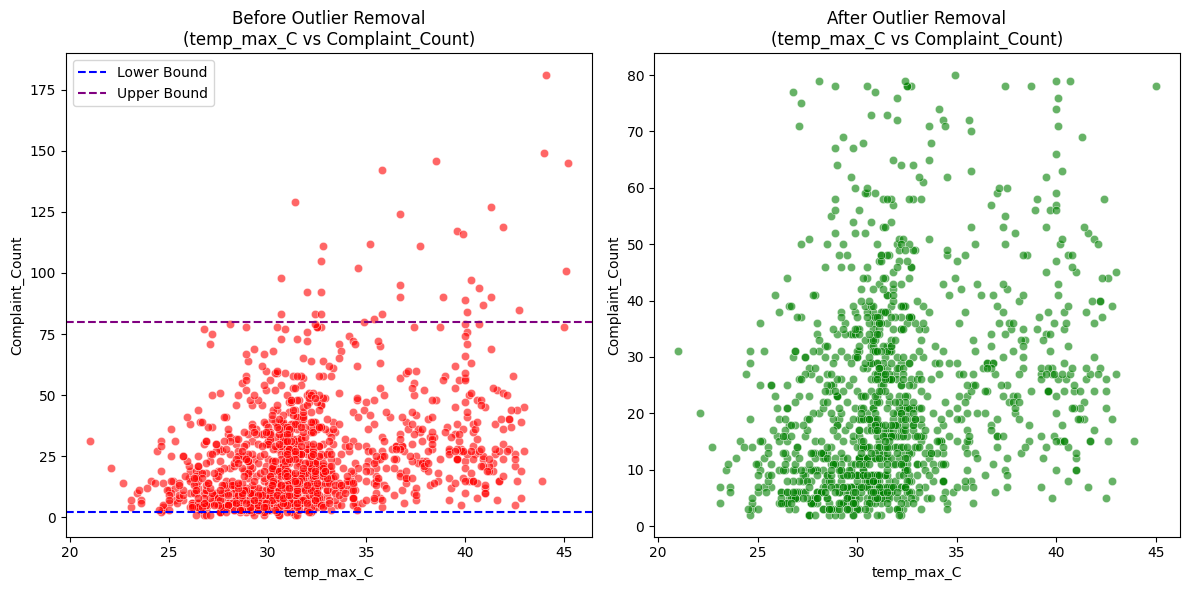

In [288]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Define your columns ---
target_col = 'Complaint_Count'        # 🔁 your target column
x_feature = 'temp_max_C'    # 🔁 your x-axis feature (e.g., 'humidity', 'day', etc.)

# --- Step 2: Define manual cutoff values ---
lowerbound = 2     # 👈 set your lower limit
upperbound = 80    # 👈 set your upper limit

# --- Step 3: Apply filtering based on manual cutoffs ---
filtered_data = df[(df[target_col] >= lowerbound) & (df[target_col] <= upperbound)]
filtered_data = filtered_data.reset_index(drop=True)

print(f"Manual Outlier Cutoffs → Lower: {lowerbound}, Upper: {upperbound}")
print("Original Shape:", df.shape)
print("Filtered Shape:", filtered_data.shape)

# --- Step 4: Scatter Plot Visualization ---
plt.figure(figsize=(12, 6))

# Before outlier removal
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x=x_feature, y=target_col, color='red', alpha=0.6)
plt.axhline(lowerbound, color='blue', linestyle='--', label='Lower Bound')
plt.axhline(upperbound, color='purple', linestyle='--', label='Upper Bound')
plt.legend()
plt.title(f"Before Outlier Removal\n({x_feature} vs {target_col})")

# After outlier removal
plt.subplot(1, 2, 2)
sns.scatterplot(data=filtered_data, x=x_feature, y=target_col, color='green', alpha=0.6)
plt.title(f"After Outlier Removal\n({x_feature} vs {target_col})")

plt.tight_layout()
plt.show()


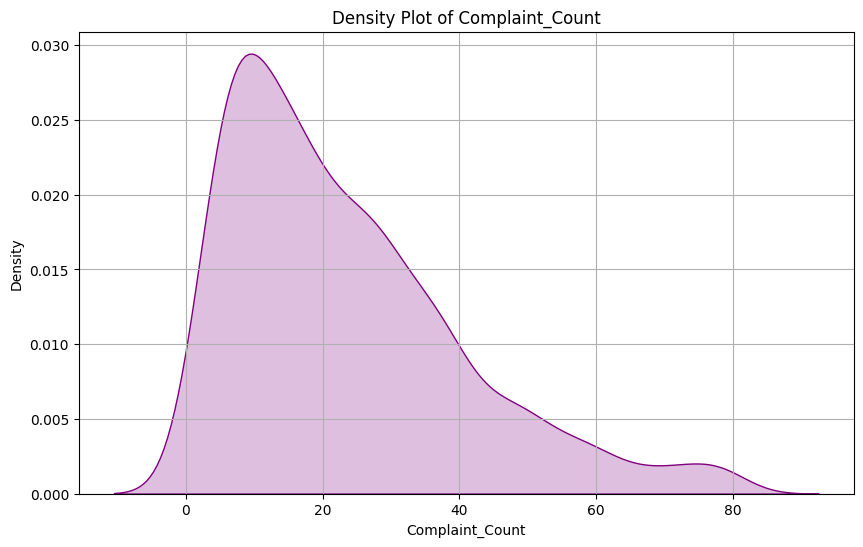

In [290]:
plt.figure(figsize=(10, 6))
sns.kdeplot(filtered_data['Complaint_Count'], shade=True, color='purple')
plt.title('Density Plot of Complaint_Count')
plt.xlabel('Complaint_Count')
plt.ylabel('Density')
plt.grid(True)
plt.show()

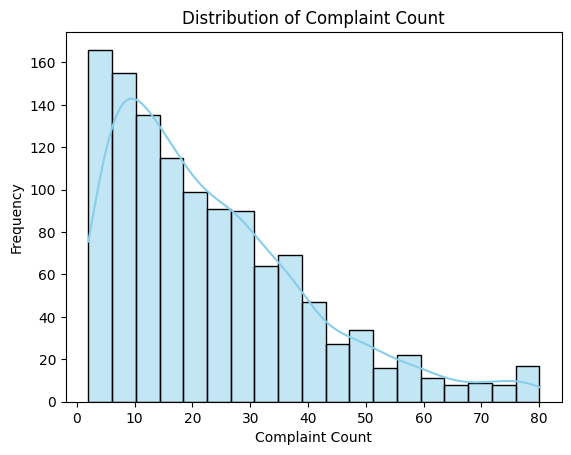

In [289]:
sns.histplot(data=filtered_data, x='Complaint_Count', kde=True, color='skyblue')
plt.title('Distribution of Complaint Count')
plt.xlabel('Complaint Count')
plt.ylabel('Frequency')
plt.show()

In [291]:
filtered_data

,time,temp_max_C,temp_min_C,precip_mm,day_of_week,month,wind_speed_max_m_s,weather_code,Complaint_Count,year,relative_humidity_2m_mean,weather_label
0,2022-06-10,41.0,30.3,0.1,4,6,16.6,51,10,2022,47,1
1,2022-06-11,41.0,30.8,0.2,5,6,25.3,51,12,2022,42,1
2,2022-06-12,39.8,29.5,0.0,6,6,16.7,3,5,2022,45,3
3,2022-06-13,40.2,29.5,0.0,0,6,13.3,3,15,2022,45,3
4,2022-06-14,39.2,30.0,8.6,1,6,19.0,63,16,2022,52,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1178,2025-10-15,31.4,22.4,0.0,2,10,6.1,0,18,2025,78,3
1179,2025-10-16,30.9,22.2,0.0,3,10,8.2,0,18,2025,75,3
1180,2025-10-17,31.0,21.7,0.0,4,10,7.8,0,17,2025,75,3
1181,2025-10-18,30.5,20.6,0.0,5,10,6.3,0,37,2025,77,3
